In [1]:
!pip3 install transformers
!pip3 install datasets
!pip3 install nltk
!pip3 install pyspellchecker

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 192 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 6.6 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 2.7 MB 1.3 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast, RobertaModel, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score
 

DEVICE = torch.device("cuda")

In [3]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=1, hidden_dropout_prob=0.05).to(DEVICE)
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [4]:
import nltk
from spellchecker import SpellChecker
spellch = SpellChecker()
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("user")

def clean_string(s):
#     s = " ".join(word for word in s.split() if word not in stopwords)
    s = s.encode('ASCII', 'ignore').decode()
    s = s.lower()
    s = ''.join([ch for ch in s if ch.isalpha() or ch == ' '])
    s = " ".join(s.split())
    if len(s) > 0 and s[-1] == ' ':
        s = s[:-1]
    if len(s) > 0 and s[0] == ' ':
        s = s[1:]
    
    # corrected = []
    # misspelled = spellch.unknown(s.split())
    # for word in s.split():
    #     if word in misspelled:
    #         corrected.append(spellch.correction(word))
    #         print(word, corrected[-1])
    #     else:
    #         corrected.append(word)
    # s = " ".join(corrected)
    return s

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from datasets import load_dataset

dataset = load_dataset("tweets_hate_speech_detection")

def cleaned(data):
     tweets = [] 
     for tweet in data['tweet']:
         tweets.append(clean_string(tweet))
     return {'cleaned': tweets}
cleaned_dataset = dataset.map(cleaned, batched=True)


train_size = int(len(cleaned_dataset["train"]) * 0.8)
val_size = len(cleaned_dataset["train"]) - train_size
train_data, val_data = random_split(cleaned_dataset["train"], [train_size, val_size], generator=torch.Generator().manual_seed(42))

Dataset tweets_hate_speech_detection downloaded and prepared to /root/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/c32a982d8b2d6233065d820ac655454174f8aaa8faddc74979cf793486acd3b0. Subsequent calls will reuse this data.


In [6]:
toxic_tweets = sum(train_data[:]['label'])
print(toxic_tweets, train_size)
print(toxic_tweets / train_size)

1787 25569
0.06988931909734444


In [7]:
from torch.utils.data import WeightedRandomSampler

batch_size = 32
# multiplier = 2    # m * t / (m * t + n)
# weights = torch.ones(train_size) + (multiplier - 1) * torch.tensor(train_data[:]['label'])
# sampler = WeightedRandomSampler(weights, train_size)
# train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [8]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-5, eps = 1e-8)
# optim = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

In [17]:
THRESHOLD = 0.810126582278481

def evaluate():
    model.eval()
    with torch.no_grad():
      correct = 0
      processed = 0
      running_loss = 0
      for i in val_loader:
          tweet = i["cleaned"]
          label = i["label"]
          tokens = tokenizer(tweet, padding=True, truncation=True,  return_tensors="pt").to(DEVICE)
          outputs = model.forward(**tokens)[0]
          result = torch.sigmoid(outputs) > THRESHOLD
          correct += accuracy_score(label, result.cpu(), normalize=False)
          processed += len(label)

          loss = criterion(outputs, label.type_as(outputs).unsqueeze(1))
          running_loss += loss.item() * len(label)

    return running_loss / processed, correct / processed

# оценим до обучения
# print(evaluate()) # 0.07117159393086188

In [11]:
def train(epoch):
    running_loss = 0
    processed = 0
    correct = 0
    model.train()
    for i in train_loader:
        tweet = i["cleaned"]
        label = i["label"].to(DEVICE)
        optim.zero_grad()
        tokens = tokenizer(tweet, padding=True, truncation=True,  return_tensors="pt").to(DEVICE)
        outputs = model.forward(**tokens)[0]

        loss = criterion(outputs, label.type_as(outputs).unsqueeze(1))
        loss.backward()
        optim.step()

        result = torch.sigmoid(outputs) > THRESHOLD
        correct += accuracy_score(label.cpu(), result.cpu(), normalize=False)

        running_loss += loss.item() * len(label)
        processed += len(label)

#         scheduler.step()
    
    return running_loss / processed, correct / processed


In [ ]:
# scheduler = get_linear_schedule_with_warmup(optim, 250 * 2, 250 * 12)

In [12]:
for epoch in range(0, 5):
  train_loss, train_acc = train(epoch)
  eval_loss, eval_acc = evaluate()
  print(epoch, train_loss, train_acc, eval_loss, eval_acc)
  if epoch % 1 == 0:
    torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optim.state_dict()
          }, f'modelState{epoch}.pth')

0 0.15165039864077892 0.9423520669560796 0.10565747111749056 0.9585484123259815
1 0.08525378463913917 0.9643709179084047 0.10472447156379354 0.9633974659784139
2 0.04842893065032536 0.9808752786577496 0.1326190082296023 0.9632410448928516
3 0.02622976727778526 0.9901443153819077 0.12375934775286478 0.9684029407164085
4 0.015701601551560744 0.9934686534475341 0.13889596908183263 0.9702799937431565


In [14]:
model_answers = torch.tensor([])
true_answers = torch.tensor([])
model.eval()
processed = 0

for i in val_loader:
    with torch.no_grad():
        tweet = i["cleaned"]
        label = i["label"]
        tokens = tokenizer(tweet, padding=True, truncation=True,  return_tensors="pt").to(DEVICE)
        outputs = model.forward(**tokens) 
        result = torch.sigmoid(outputs[0])
        model_answers = torch.cat((model_answers, result.squeeze(1).cpu()))
        true_answers = torch.cat((true_answers, label))

        processed += len(label)

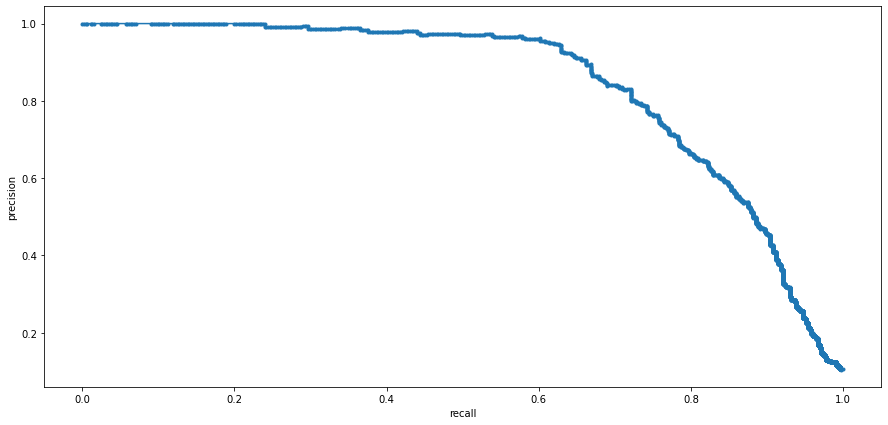

In [15]:
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve

prc = precision_recall_curve(true_answers.detach().numpy(), model_answers.detach().numpy(), pos_label = 1)
pyplot.figure(figsize=(15,7))
pyplot.plot(prc[1], prc[0], marker='.')

# for x, y, z in zip(prc[1], prc[0], prc[2]):
#     label = "{:.1f}".format(1 - z)
#     pyplot.annotate(label, 
#                  (x,y), 
#                  textcoords="offset points",
#                  xytext=(0,10), 
#                  ha='center')

pyplot.xlabel('recall')
pyplot.ylabel('precision')
pyplot.show()


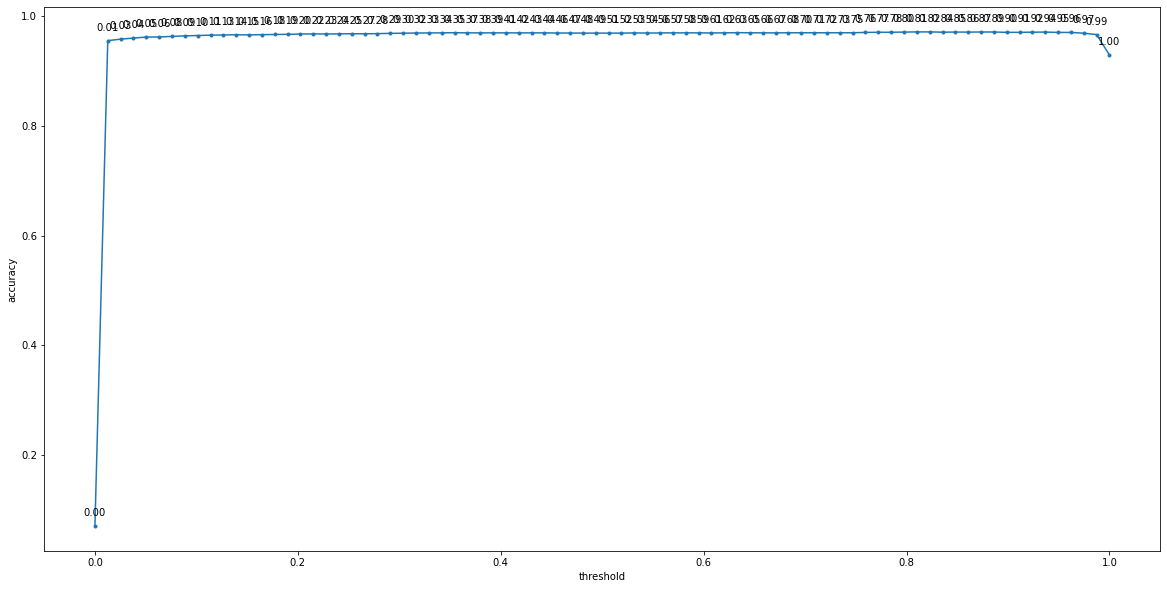

0.810126582278481 0.970905678085406


In [16]:
import numpy as np

xs = []
ys = []
mxthr = 0
mx = 0

for thr in np.linspace(0,1,80):
    score = accuracy_score(true_answers, model_answers > thr)
    xs.append(thr)
    ys.append(score)
    if score > mx:
        mx = score
        mxthr = thr

pyplot.figure(figsize=(20,10))
pyplot.plot(xs, ys, marker='.')

for x, y in zip(xs, ys):

    label = "{:.2f}".format(x)

    pyplot.annotate(label, 
                 (x,y), 
                 textcoords="offset points",
                 xytext=(0,10), 
                 ha='center')

pyplot.xlabel('threshold')
pyplot.ylabel('accuracy')
pyplot.show()

print(mxthr, mx)

In [18]:
ans = model_answers > THRESHOLD
tp = 0
fp = 0
tn = 0
fn = 0

for mansw, answ in zip(ans, true_answers):
    if answ == 1 and mansw == 1:
        tp += 1
    if answ == 0 and mansw == 0:
        tn += 1
    if answ == 1 and mansw == 0:
        fp += 1
    if answ == 0 and mansw == 1:
        fn += 1

print(tp, fp)
print(tn, fn)

301 154
5906 32


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# checkpoint = torch.load('drive/MyDrive/modelState199.pth')
# checkpoint = torch.load('modelState59.pth')
checkpoint = torch.load('../input/modelstatebest/modelState4.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optim.load_state_dict(checkpoint['optimizer_state_dict'])